## Drift Align Test

In a drift alignment test the mount is measured for how far off a polar alignment by measuring the drift in the altitude and azimuth axis while tracking near the galactic equator. Note that this procedure is still performed with an equatorial mount, you are simply measuring how far off from the celestial pole your mount is in Alt/Az coordinates.

To test the altitude misalignment a star near the galactic equator is tracked from a point near the horizon until it begins to drift on the declination axis.

To test the azimuthal misalignment a star near the galactic equator is tracked near the meridian and again the drift of the declination axis is monitored.

There are many subtleties to the procedure that are glossed over here. For more information see, [here](http://www.minorplanet.info/ObsGuides/Misc/DriftPolarAlignment.htm) and [here](https://sites.google.com/site/openphdguiding/phd2-drift-alignment), as well as elsewhere online.

In [1]:
from glob import glob

from astropy import units as u
from astropy.io import fits

from matplotlib import pyplot as plt
from matplotlib import markers
import pandas
from matplotlib import rcParams
plt.style.use('bmh')

rcParams['axes.formatter.useoffset'] = False

from pocs.images import Image
from pocs.utils import images as img_utils

%matplotlib inline

### Gather files

In [2]:
# Dates of the test
dates = ['20170115T083433', '20170115T052256']

In [3]:
all_files = {
    'az_east': {},
    'az_west': {},
    'alt_east': {},
    'alt_west': {},
}

for date in dates:
    all_files['az_east'][date] = glob('images/drift_align/{}*Az_East*.fits'.format(date))
    all_files['alt_east'][date] = glob('images/drift_align/{}*Alt_East*.fits'.format(date))
    all_files['az_west'][date] = glob('images/drift_align/{}*Az_West*.fits'.format(date))
    all_files['alt_west'][date] =  glob('images/drift_align/{}*Alt_West*.fits'.format(date))

### Gather WCS info from files

In [4]:
data = {}

for name in all_files.keys():
    data[name] = {}
    for date, files in all_files[name].items():
        data[name][date] = { 
                'Cam00': { 'time': [], 'd_dec': [], 'dt': [], 'dec': [] },
                'Cam01': { 'time': [], 'd_dec': [], 'dt': [], 'dec': [] }
        }

        files.sort()

        for i, f in enumerate(files):
            wcsinfo = img_utils.get_wcsinfo(f)

            dec = wcsinfo['dec_center']
            t = pandas.to_datetime(fits.getval(f, 'DATE-OBS'))

            if 'Cam00' in f:
                cam_name = 'Cam00'
            else:
                cam_name = 'Cam01'

            try:
                dec0 = data[name][date][cam_name]['dec'][0]
                t0 = data[name][date][cam_name]['time'][0]
            except:
                dec0 = dec
                t0 = t

            data[name][date][cam_name]['dec'].append(dec)
            data[name][date][cam_name]['d_dec'].append((dec - dec0).to(u.arcsec).value)
            data[name][date][cam_name]['time'].append(t)
            data[name][date][cam_name]['dt'].append((t - t0).seconds)

### Plot

In [5]:
# Plotting options
color = {
    'alt_east': 'green',
    'alt_west': 'blue',
    'az_east': 'red',
    'az_west': 'purple'
}

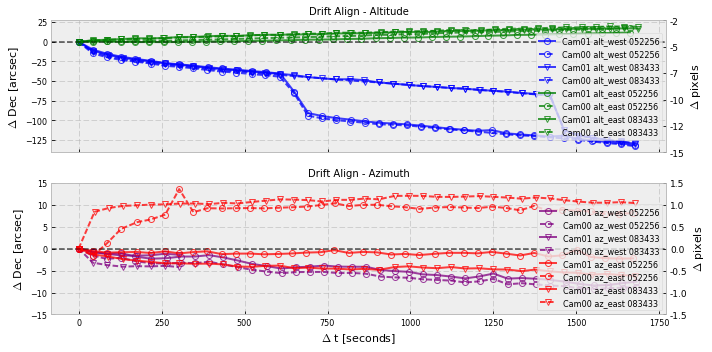

In [6]:
f, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

for name in data.keys():
    if 'alt' in name:
        i = 0
    else:
        i = 1

    for j, date in enumerate(data[name].keys()):
        for camera in data[name][date].keys():
            if camera == 'Cam00':
                line = '--'
            else:
                line = '-'

            ax[i].plot(
                data[name][date][camera]['dt'], data[name][date][camera]['d_dec'], 
                marker=markers.MarkerStyle.filled_markers[j], 
                ms=6, markerfacecolor='None', markeredgewidth=1, 
                markeredgecolor=color[name], alpha=0.75,
                ls=line, color=color[name], label='{} {} {}'.format(camera, name, date.split('T')[-1])
            )

    if i == 0:
        which = 'Altitude'
    else:
        which = 'Azimuth'    
    
    ax[i].legend(fontsize=8)

    ax[i].set_ylabel('$\Delta$ Dec [arcsec]', fontsize=11)
    ax[i].tick_params(labelsize=8)

    ax[i].set_title('Drift Align - {}'.format(which), fontsize=10)
    ax[i].axhline(y=0, c='k', ls='--', lw=2, alpha=0.3)

    
pixel_ax = ax[0].twinx()
pixel_ax.set_yticklabels(["{:.0f}".format(x / 10.3) for x in ax[0].get_yticks()], fontsize=9)
pixel_ax.set_ylabel('$\Delta$ pixels', fontsize=11)
pixel_ax.grid(False)    

ax[1].set_ylim(-15, 15)
pixel_ax2 = ax[1].twinx()
pixel_ax2.set_ylim(-1.5, 1.5)
pixel_ax2.set_yticklabels(["{:.01f}".format(x / 10.3) for x in ax[1].get_yticks()], fontsize=9)
pixel_ax2.set_ylabel('$\Delta$ pixels', fontsize=11)
pixel_ax2.grid(False)    
    
ax[1].set_xlabel('$\Delta$ t [seconds]', fontsize=11)
    
plt.tight_layout()
plt.savefig('drift_align.png', dpi=300)